Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
=== Secured Text-Based CAPTCHA with Style Transfer ===
Using dataset from: /content/drive/MyDrive/captcha_samples
Generator initialized successfully!

Generating enhanced CAPTCHAs...

Processing CAPTCHA: 7gnge
Using style: style_1.jpg
Iter 0: Total Loss=3358889728.00, Content=0.00, Style=335888973824.00
Iter 10: Total Loss=4940518912.00, Content=192068.31, Style=301983596544.00
Iter 20: Total Loss=4098788352.00, Content=154169.27, Style=255709577216.00
Iter 30: Total Loss=3629011968.00, Content=131414.31, Style=231486898176.00
Iter 40: Total Loss=3343713792.00, Content=116596.44, Style=217774931968.00


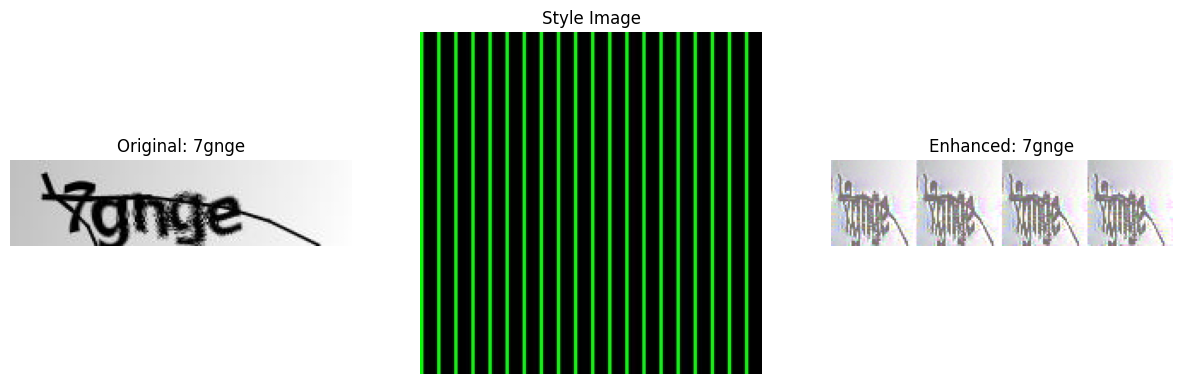

Saved to: /content/drive/MyDrive/enhanced_captchas/enhanced_7gnge.png

Processing CAPTCHA: 4dgf7
Using style: style_0.jpg
Iter 0: Total Loss=17053068288.00, Content=0.00, Style=1705306882048.00
Iter 10: Total Loss=16664597504.00, Content=190485.52, Style=1475974266880.00
Iter 20: Total Loss=15998009344.00, Content=200984.95, Style=1398815981568.00
Iter 30: Total Loss=15629403136.00, Content=221376.62, Style=1341563731968.00
Iter 40: Total Loss=15383398400.00, Content=239146.03, Style=1299193921536.00


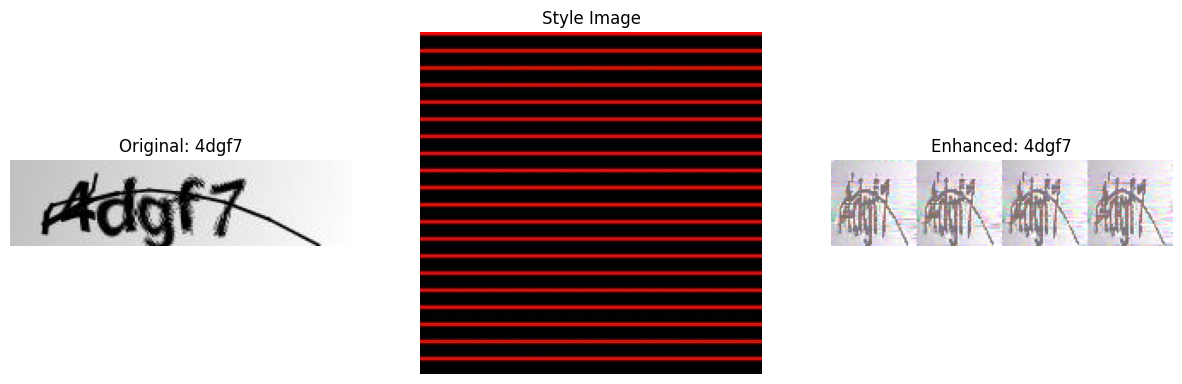

Saved to: /content/drive/MyDrive/enhanced_captchas/enhanced_4dgf7.png

Processing CAPTCHA: 3w2bw
Using style: style_2.jpg
Iter 0: Total Loss=2692486912.00, Content=0.00, Style=269248708608.00
Iter 10: Total Loss=3184456192.00, Content=183367.47, Style=135078141952.00
Iter 20: Total Loss=2618979328.00, Content=137989.42, Style=123908513792.00
Iter 30: Total Loss=2308367616.00, Content=109063.17, Style=121773596672.00
Iter 40: Total Loss=2128443520.00, Content=92478.66, Style=120365694976.00


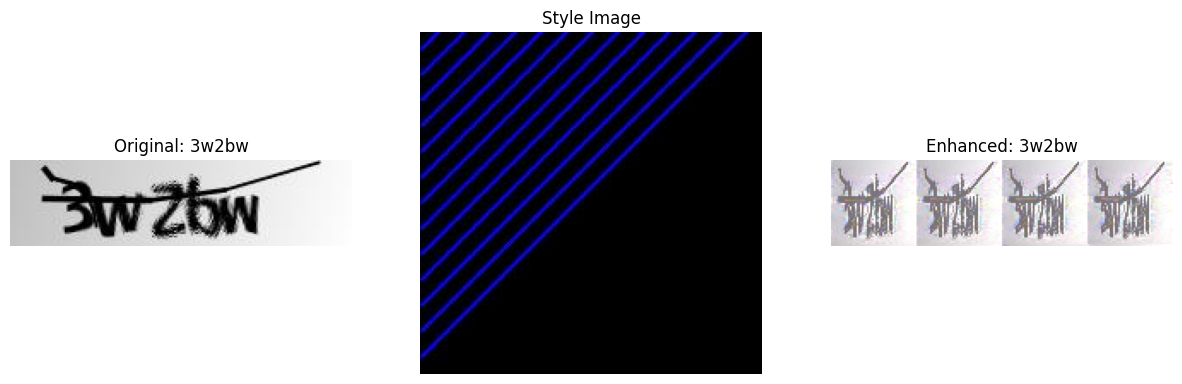

Saved to: /content/drive/MyDrive/enhanced_captchas/enhanced_3w2bw.png


In [13]:
# Secured Text-Based CAPTCHA with Style Transfer - Final Fixed Version
# Using Google Drive for dataset storage

# Install required packages
!pip install -q tensorflow matplotlib numpy

# Import libraries
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import vgg19
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import Image, ImageDraw, ImageFont
import random
import string
import matplotlib.pyplot as plt
from google.colab import drive

# ====================== MOUNT GOOGLE DRIVE ======================
drive.mount('/content/drive')

# ====================== SETUP PATHS ======================
DATASET_PATH = '/content/drive/MyDrive/captcha_samples'
STYLE_IMAGES_PATH = '/content/drive/MyDrive/style_images'
OUTPUT_PATH = '/content/drive/MyDrive/enhanced_captchas'

# Create directories if they don't exist
os.makedirs(STYLE_IMAGES_PATH, exist_ok=True)
os.makedirs(OUTPUT_PATH, exist_ok=True)

# ====================== CONSTANTS ======================
IMAGE_WIDTH = 200
IMAGE_HEIGHT = 50
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
CONTENT_WEIGHT = 1e4  # Higher weight to preserve text
STYLE_WEIGHT = 1e-2

# ====================== STYLE TRANSFER MODEL ======================
class StyleTransferModel:
    def __init__(self):
        # Use these specific layers for style and content
        self.content_layer = 'block4_conv2'  # Deeper layer for better content representation
        self.style_layers = ['block1_conv1', 'block2_conv1',
                           'block3_conv1', 'block4_conv1']
        self.model = self.build_model()

    def build_model(self):
        # Load VGG19 without top layers
        vgg = vgg19.VGG19(include_top=False, weights='imagenet')
        vgg.trainable = False

        # Get output layers
        style_outputs = [vgg.get_layer(name).output for name in self.style_layers]
        content_output = vgg.get_layer(self.content_layer).output

        # Build model
        return tf.keras.models.Model(vgg.input, [style_outputs, content_output])

    def preprocess_image(self, image_path):
        img = load_img(image_path, target_size=IMAGE_SIZE)
        img = img_to_array(img)
        img = np.expand_dims(img, axis=0)
        img = vgg19.preprocess_input(img)
        return tf.convert_to_tensor(img)

    def deprocess_image(self, x):
        x = x.numpy()
        x = x.reshape((IMAGE_HEIGHT, IMAGE_WIDTH, 3))
        x[:, :, 0] += 103.939
        x[:, :, 1] += 116.779
        x[:, :, 2] += 123.68
        x = x[:, :, ::-1]
        x = np.clip(x, 0, 255).astype('uint8')
        return x

    def gram_matrix(self, input_tensor):
        # Flatten the feature maps
        channels = int(input_tensor.shape[-1])
        a = tf.reshape(input_tensor, [-1, channels])
        n = tf.cast(tf.shape(a)[0], tf.float32)
        gram = tf.matmul(a, a, transpose_a=True)
        return gram / n

    def compute_loss(self, generated_image, style_targets, content_target):
        # Get model outputs
        style_outputs, content_output = self.model(generated_image)

        # Content loss (simple MSE)
        content_loss = tf.reduce_mean((content_output - content_target)**2)

        # Style loss (using Gram matrices)
        style_loss = 0
        for style_output, style_target in zip(style_outputs, style_targets):
            style_loss += tf.reduce_mean((self.gram_matrix(style_output) - style_target)**2)
        style_loss /= len(style_layers)

        total_loss = CONTENT_WEIGHT * content_loss + STYLE_WEIGHT * style_loss
        return total_loss, content_loss, style_loss

    def transfer_style(self, content_path, style_path, iterations=50, learning_rate=2.0):
        # Load and preprocess images
        content_image = self.preprocess_image(content_path)
        style_image = self.preprocess_image(style_path)

        # Initialize generated image with content image
        generated_image = tf.Variable(content_image)

        # Get targets
        style_targets, _ = self.model(style_image)
        _, content_target = self.model(content_image)

        # Convert style targets to Gram matrices
        style_targets = [self.gram_matrix(style_target) for style_target in style_targets]

        # Optimizer
        opt = tf.optimizers.Adam(learning_rate=learning_rate)

        # Training loop
        best_loss = float('inf')
        best_image = None

        for i in range(iterations):
            with tf.GradientTape() as tape:
                total_loss, content_loss, style_loss = self.compute_loss(
                    generated_image, style_targets, content_target)

            gradients = tape.gradient(total_loss, generated_image)
            opt.apply_gradients([(gradients, generated_image)])
            generated_image.assign(tf.clip_by_value(generated_image, 0.0, 255.0))

            if total_loss < best_loss:
                best_loss = total_loss
                best_image = self.deprocess_image(generated_image)

            if i % 10 == 0:
                print(f"Iter {i}: Total Loss={total_loss:.2f}, Content={content_loss:.2f}, Style={style_loss:.2f}")

        return best_image

# ====================== CAPTCHA GENERATOR ======================
class CAPTCHAGenerator:
    def __init__(self, dataset_path=DATASET_PATH):
        self.dataset_path = dataset_path
        self.style_model = StyleTransferModel()
        self.style_images = self.load_style_images()

    def load_style_images(self):
        if not os.listdir(STYLE_IMAGES_PATH):
            print("Creating sample style images...")
            colors = [(255,0,0), (0,255,0), (0,0,255)]
            patterns = ["horizontal", "vertical", "diagonal"]

            for i, (color, pattern) in enumerate(zip(colors, patterns)):
                img = Image.new('RGB', IMAGE_SIZE, (0, 0, 0))
                draw = ImageDraw.Draw(img)

                if pattern == "horizontal":
                    for y in range(0, IMAGE_HEIGHT, 5):
                        draw.line([(0, y), (IMAGE_WIDTH, y)], fill=color, width=1)
                elif pattern == "vertical":
                    for x in range(0, IMAGE_WIDTH, 5):
                        draw.line([(x, 0), (x, IMAGE_HEIGHT)], fill=color, width=1)
                else:  # diagonal
                    for d in range(-IMAGE_WIDTH, IMAGE_WIDTH, 5):
                        draw.line([(d, 0), (0, d)], fill=color, width=1)

                img.save(f"{STYLE_IMAGES_PATH}/style_{i}.jpg")

        return [f"{STYLE_IMAGES_PATH}/{f}" for f in os.listdir(STYLE_IMAGES_PATH) if f.endswith(('.jpg', '.png'))]

    def get_random_captcha(self):
        captcha_files = [f for f in os.listdir(self.dataset_path) if f.endswith('.png')]
        if not captcha_files:
            raise FileNotFoundError(f"No CAPTCHA images found in {self.dataset_path}")

        selected_file = random.choice(captcha_files)
        captcha_text = os.path.splitext(selected_file)[0]
        return os.path.join(self.dataset_path, selected_file), captcha_text

    def generate_enhanced_captcha(self):
        os.makedirs(OUTPUT_PATH, exist_ok=True)

        # Get random CAPTCHA and style image
        captcha_path, captcha_text = self.get_random_captcha()
        style_path = random.choice(self.style_images)

        print(f"\nProcessing CAPTCHA: {captcha_text}")
        print(f"Using style: {os.path.basename(style_path)}")

        # Apply style transfer
        enhanced_image = self.style_model.transfer_style(captcha_path, style_path)

        # Save result
        enhanced_img = Image.fromarray(enhanced_image)
        output_path = os.path.join(OUTPUT_PATH, f"enhanced_{captcha_text}.png")
        enhanced_img.save(output_path)

        return captcha_path, style_path, output_path, captcha_text

# ====================== MAIN EXECUTION ======================
def main():
    print("=== Secured Text-Based CAPTCHA with Style Transfer ===")
    print(f"Using dataset from: {DATASET_PATH}")

    # Initialize generator
    try:
        generator = CAPTCHAGenerator()
        print("Generator initialized successfully!")
    except Exception as e:
        print(f"Error initializing generator: {e}")
        return

    # Generate and display 3 enhanced CAPTCHAs
    print("\nGenerating enhanced CAPTCHAs...")
    for i in range(3):
        try:
            original_path, style_path, enhanced_path, text = generator.generate_enhanced_captcha()

            # Display results
            plt.figure(figsize=(15, 5))

            plt.subplot(1, 3, 1)
            plt.imshow(plt.imread(original_path))
            plt.title(f"Original: {text}")
            plt.axis('off')

            plt.subplot(1, 3, 2)
            plt.imshow(plt.imread(style_path))
            plt.title("Style Image")
            plt.axis('off')

            plt.subplot(1, 3, 3)
            plt.imshow(plt.imread(enhanced_path))
            plt.title(f"Enhanced: {text}")
            plt.axis('off')

            plt.show()
            print(f"Saved to: {enhanced_path}")

        except Exception as e:
            print(f"Error generating CAPTCHA {i+1}: {e}")

if __name__ == "__main__":
    main()